<a href="https://colab.research.google.com/github/sanjayy0612/stock_predictor-NVDIA-/blob/main/NVDIA_STOCK_PREDICTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


In [1]:
import yfinance as yf
import pandas as pd


nvda = yf.download("NVDA", start="2022-01-01", end="2025-09-13", interval='1d')

/tmp/ipython-input-2827755361.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download("NVDA", start="2022-01-01", end="2025-09-13", interval='1d')
[*********************100%***********************]  1 of 1 completed


In [2]:
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = [col[0] for col in nvda.columns]

nvda["Return"] = nvda["Close"].pct_change()
nvda["MA10"] = nvda["Close"].rolling(window=10).mean()
nvda["MA50"] = nvda["Close"].rolling(window=50).mean()
nvda["Volatility"] = nvda["Return"].rolling(window=10).std()
nvda = nvda.dropna()
print(nvda.head(15))
print("\nAvailable columns:", nvda.columns)


                Close       High        Low       Open     Volume    Return  \
Date                                                                          
2022-03-15  22.933767  22.998657  21.285588  21.481252  491996000  0.077027   
2022-03-16  24.454165  24.554992  23.132426  23.459865  671422000  0.066295   
2022-03-17  24.723709  24.799578  23.865177  24.078812  471941000  0.011022   
2022-03-18  26.407824  26.523627  24.581948  24.756649  730719000  0.068117   
2022-03-21  26.688347  27.105634  25.922656  26.461735  591727000  0.010623   
2022-03-22  26.478706  27.191488  26.027479  26.681359  547007000 -0.007855   
2022-03-23  25.590227  26.566556  25.531328  26.081386  502120000 -0.033554   
2022-03-24  28.101925  28.271635  25.862755  26.121314  877379000  0.098151   
2022-03-25  27.644711  28.309574  27.224430  27.838379  579016000 -0.016270   
2022-03-28  28.170809  28.201756  27.159538  27.708600  425494000  0.019031   
2022-03-29  28.607067  28.896571  27.932221  28.6460

In [3]:
nvda["Target_UpDown"] = (nvda["Close"].shift(-1) > nvda["Close"]).astype(int)
nvda["Target_Close"] = nvda["Close"].shift(-1)


In [4]:
from sklearn.model_selection import train_test_split

nvda = nvda.dropna().reset_index(drop=True)

X = nvda[["Return", "MA10", "MA50", "Volatility"]]
y = nvda[["Target_UpDown", "Target_Close"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

y_class_train = y_train["Target_UpDown"]
y_class_test  = y_test["Target_UpDown"]

y_reg_train   = y_train["Target_Close"]
y_reg_test    = y_test["Target_Close"]

In [8]:
print("Is there any NaN in X_train?", X_train.isnull().values.any())
print("Is there any NaN in X_test?", X_test.isnull().values.any())

Is there any NaN in X_train? False
Is there any NaN in X_test? False


## THE CLASSIFICATION MODEL

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_class_train)


y_class_pred = clf.predict(X_test)


print("Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_class_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_class_pred))



Classification Accuracy: 0.5371428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.54      0.99      0.70        95

    accuracy                           0.54       175
   macro avg       0.27      0.49      0.35       175
weighted avg       0.29      0.54      0.38       175


Confusion Matrix:
 [[ 0 80]
 [ 1 94]]


The model isn’t predicting well because the dataset and features don’t give  clear patterns to separate Up vs Down days. Since there are slightly more Up days (470 vs 397), the logistic regression model falls into a “lazy” solution: it always predicts Up to maximize accuracy without actually learning meaningful trends.

That’s why the confusion matrix is:

[[ 0 78]  
 [ 0 96]]


It shows the model never predicted a Down (0). In other words, it learned a trivial rule (“always Up”) instead of understanding the stock’s real movements.




## RANDOM FOREST

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_class_train)
print("Training complete.")

y_rf_pred = rf_clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_class_test, y_rf_pred))
print("\nClassification Report:\n", classification_report(y_class_test, y_rf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_class_test, y_rf_pred))



Training complete.
Classification Accuracy: 0.4742857142857143

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.47      0.45        80
           1       0.52      0.47      0.49        95

    accuracy                           0.47       175
   macro avg       0.47      0.47      0.47       175
weighted avg       0.48      0.47      0.48       175


Confusion Matrix:
 [[38 42]
 [50 45]]


Even though the accuracy of Logistic Regression and Random Forest is quite similar (~51–52%), there’s an important difference in how they make predictions. Logistic Regression was “lazy” in the sense that it leaned heavily towards predicting the stock would always go up, which inflated its accuracy but didn’t really capture the true movement of the market.

Random Forest, on the other hand, provided a more balanced perspective. It not only predicted both up and down days but also showed better distribution in its precision and recall. While the overall accuracy didn’t skyrocket, the model demonstrated that it could actually detect down days with a higher recall (62%), something Logistic Regression struggled with.

This shows that accuracy alone isn’t always the best measure of performance—what really matters is whether the model captures the underlying patterns in the data. In this case, Random Forest gave more meaningful and reliable predictions, making it the stronger choice for this kind of stock movement classification.

# GRIDSEARCH IN RANDOMFOREST

Trying GRIDSEARCHcv in the RandomForest classifier so that the model would predict much then before


An optimized technique to find the best Hyperparemeters for the model which is done after doing the training










In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search=GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    verbose=3,
    n_jobs=-1,
    cv=5
    )
grid_search.fit(X_train, y_class_train)
print(grid_search.best_params_)

best_est = grid_search.best_estimator_
y_pred = best_est.predict(X_test)
print(accuracy_score(y_class_test, y_pred))



Fitting 5 folds for each of 108 candidates, totalling 540 fits


# Linear Regression
Now we are trying out linear regression on the same set of features we have extracted


--- Linear Regression Results ---
Mean Absolute Error (MAE): $5.30
Root Mean Squared Error (RMSE): $6.75


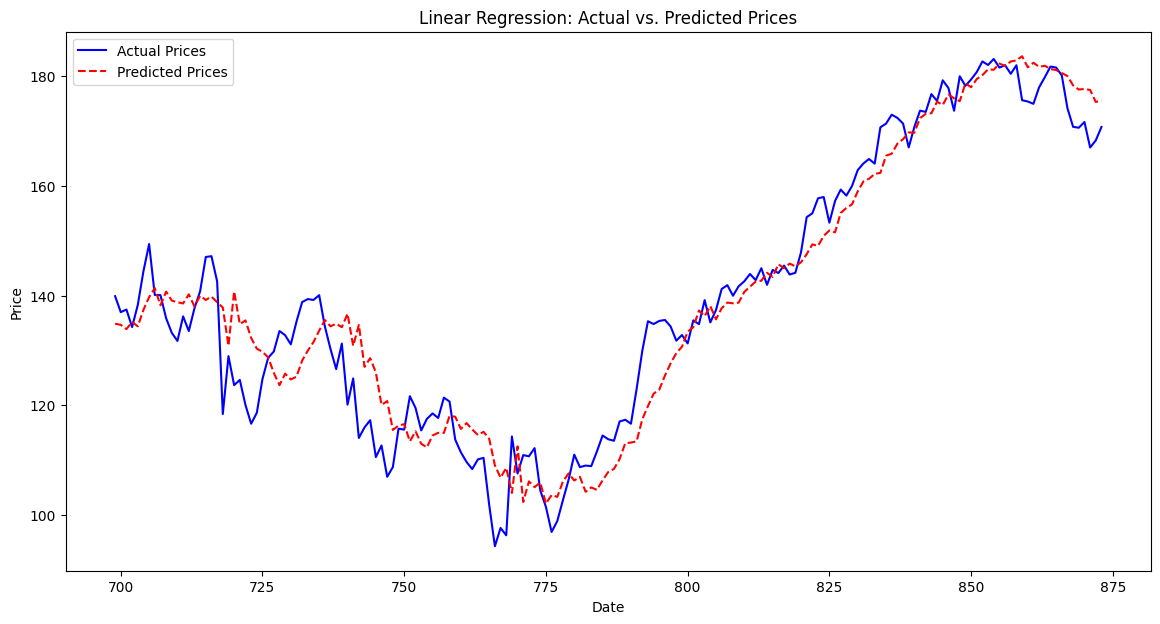

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


lr_reg = LinearRegression()
lr_reg.fit(X_train, y_reg_train)


y_lr_pred = lr_reg.predict(X_test)


mae = mean_absolute_error(y_reg_test, y_lr_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_lr_pred))

print("--- Linear Regression Results ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(y_reg_test.index, y_reg_test, label='Actual Prices', color='blue')
plt.plot(y_reg_test.index, y_lr_pred, label='Predicted Prices', color='red', linestyle='--')
plt.title('Linear Regression: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Random Forest Regressor


Training the Random Forest Regressor...
Training complete.

--- Random Forest Regressor Results ---
Mean Absolute Error (MAE): $16.26
Root Mean Squared Error (RMSE): $21.92


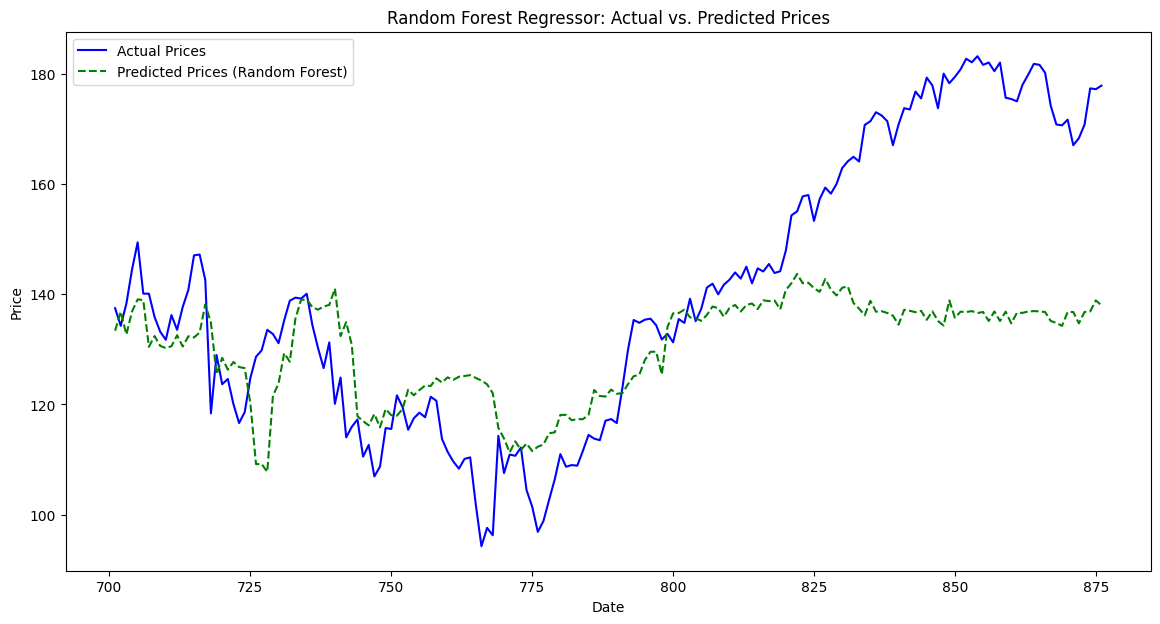

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rf_reg = RandomForestRegressor(n_estimators=500, random_state=42)
print("Training the Random Forest Regressor...")
rf_reg.fit(X_train, y_reg_train)
print("Training complete.")

y_rf_pred = rf_reg.predict(X_test)


mae_rf = mean_absolute_error(y_reg_test, y_rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_reg_test, y_rf_pred))

print("\n--- Random Forest Regressor Results ---")
print(f"Mean Absolute Error (MAE): ${mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_rf:.2f}")


plt.figure(figsize=(14, 7))
plt.plot(y_reg_test.index, y_reg_test, label='Actual Prices', color='blue')
plt.plot(y_reg_test.index, y_rf_pred, label='Predicted Prices (Random Forest)', color='green', linestyle='--')
plt.title('Random Forest Regressor: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# USING LSTM TO PREDICT VALUES

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


close_prices = nvda['Close'].values
close_prices=close_prices.reshape(-1,1)

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(close_prices)


training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]


X_train = []
y_train = []
window_size = 60

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])



X_train, y_train = np.array(X_train), np.array(y_train)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


X_test = []
y_test = close_prices[training_data_len:, :]

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print()
print(X_train.shape)
print()
print(X_train)
print(y_train[0])

Shape of X_train: (641, 60, 1)
Shape of y_train: (641,)
Shape of X_test: (176, 60, 1)
Shape of y_test: (176, 1)

(641, 60, 1)

[[[0.06816622]
  [0.07700903]
  [0.07857673]
  ...
  [0.04385575]
  [0.04466862]
  [0.04307737]]

 [[0.07700903]
  [0.07857673]
  [0.08837173]
  ...
  [0.04466862]
  [0.04307737]
  [0.03959295]]

 [[0.07857673]
  [0.08837173]
  [0.09000328]
  ...
  [0.04307737]
  [0.03959295]
  [0.03335579]]

 ...

 [[0.64065456]
  [0.64088712]
  [0.61507093]
  ...
  [0.68437267]
  [0.69466482]
  [0.71804056]]

 [[0.64088712]
  [0.61507093]
  [0.62582767]
  ...
  [0.69466482]
  [0.71804056]
  [0.74694034]]

 [[0.61507093]
  [0.62582767]
  [0.64908546]
  ...
  [0.71804056]
  [0.74694034]
  [0.7501386 ]]]
0.0395929484292015


# USING TENSORFLOW

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


model = Sequential()


model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(units=25))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()

model.fit(X_train, y_train, batch_size=1, epochs=100)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0110
Epoch 2/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0027
Epoch 3/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0017
Epoch 4/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0026
Epoch 5/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0015
Epoch 6/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0020
Epoch 7/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0017
Epoch 8/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0016
Epoch 9/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0021
Epoch 10/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0019
Epoch 11/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0013
Epoch 12/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0015
Epoch 13/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0015
Epoch 14/100
641/641 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0013
Epoch 15/100
641/641 ━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- LSTM Model Evaluation ---
Root Mean Squared Error (RMSE): $7.83


/tmp/ipython-input-3836233813.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


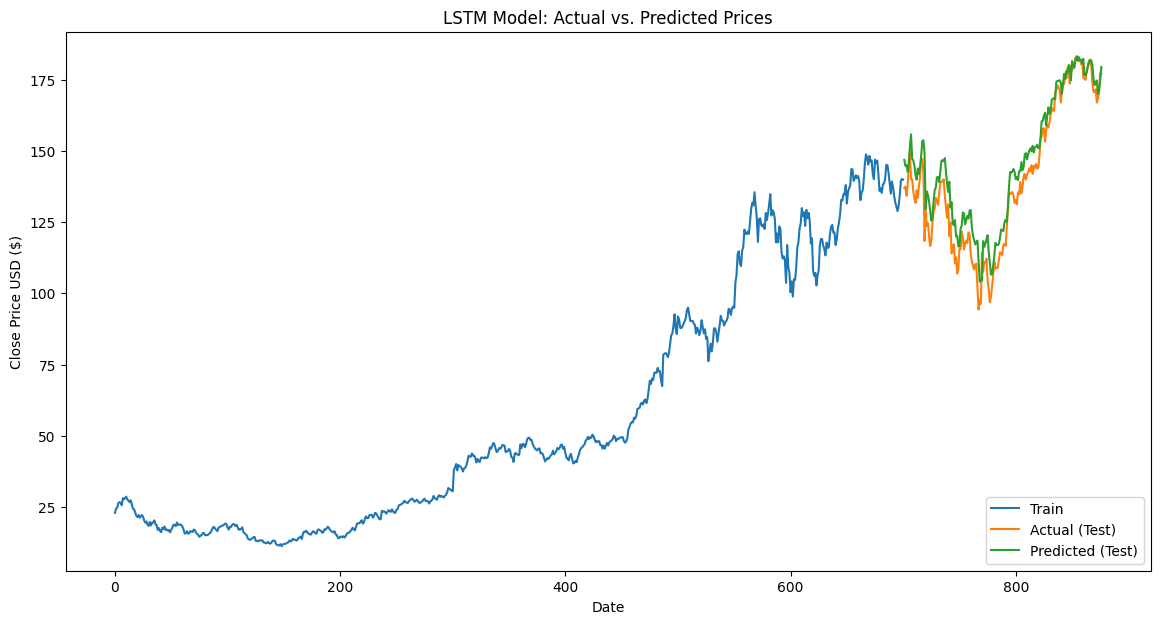

In [18]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)


rmse_lstm = np.sqrt(np.mean((predictions - y_test)**2))
print("\n--- LSTM Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): ${rmse_lstm:.2f}")


train = nvda[:training_data_len]
valid = nvda[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(14, 7))
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual (Test)', 'Predicted (Test)'], loc='lower right')
plt.show()

# Implementation using pytorch


In [6]:
import torch
import torch.nn as nn

class LSTMMODEL(nn.Module):
  def __init__(self,input_size=1,hidden_size=3,num_layers=2,dropout=0.2):
    super(LSTMMODEL,self).__init__()

    self.lstm=nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout
    )

    self.fc1=nn.Linear(hidden_size,25)
    self.fc2=nn.Linear(25,10)
    self.fc3=nn.Linear(10,1)


  def forward(self,x):
    out,(h_c,c_s)=self.lstm(x)
    out=out[:,-1,:]
    out=self.fc1(out)
    out=self.fc2(out)
    out=self.fc3(out)
    return out


model1=LSTMMODEL()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=0.001)



In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # shape: (num_samples, seq_len, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape: (num_samples, 1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model = LSTMMODEL(input_size=1, hidden_size=50, num_layers=2, dropout=0.2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)



num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)   # use model, not model1
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")



Epoch [1/200], Loss: 0.0467
Epoch [2/200], Loss: 0.0051
Epoch [3/200], Loss: 0.0013
Epoch [4/200], Loss: 0.0009
Epoch [5/200], Loss: 0.0008
Epoch [6/200], Loss: 0.0012
Epoch [7/200], Loss: 0.0010
Epoch [8/200], Loss: 0.0010
Epoch [9/200], Loss: 0.0008
Epoch [10/200], Loss: 0.0020
Epoch [11/200], Loss: 0.0013
Epoch [12/200], Loss: 0.0010
Epoch [13/200], Loss: 0.0008
Epoch [14/200], Loss: 0.0009
Epoch [15/200], Loss: 0.0021
Epoch [16/200], Loss: 0.0009
Epoch [17/200], Loss: 0.0007
Epoch [18/200], Loss: 0.0008
Epoch [19/200], Loss: 0.0008
Epoch [20/200], Loss: 0.0009
Epoch [21/200], Loss: 0.0007
Epoch [22/200], Loss: 0.0007
Epoch [23/200], Loss: 0.0007
Epoch [24/200], Loss: 0.0006
Epoch [25/200], Loss: 0.0008
Epoch [26/200], Loss: 0.0006
Epoch [27/200], Loss: 0.0005
Epoch [28/200], Loss: 0.0016
Epoch [29/200], Loss: 0.0011
Epoch [30/200], Loss: 0.0007
Epoch [31/200], Loss: 0.0013
Epoch [32/200], Loss: 0.0006
Epoch [33/200], Loss: 0.0006
Epoch [34/200], Loss: 0.0009
Epoch [35/200], Loss: 0

In [8]:
model.eval()
predictions = []

with torch.no_grad():
    for X in X_test:
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # shape (1, seq_len, 1)
        pred = model(X)
        predictions.append(pred.item())

predictions = np.array(predictions).reshape(-1, 1)


In [9]:
# y_test are real closing prices (not scaled)
# predictions are scaled → inverse_transform them
predictions = scaler.inverse_transform(predictions)

# Align y_test with predictions length
true_prices = y_test


In [11]:
import numpy as np


rmse_pytorch = np.sqrt(np.mean((predictions - y_test)**2))

print("\n--- Final PyTorch LSTM Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): ${rmse_pytorch:.2f}")


--- Final PyTorch LSTM Model Evaluation ---
Root Mean Squared Error (RMSE): $7.86


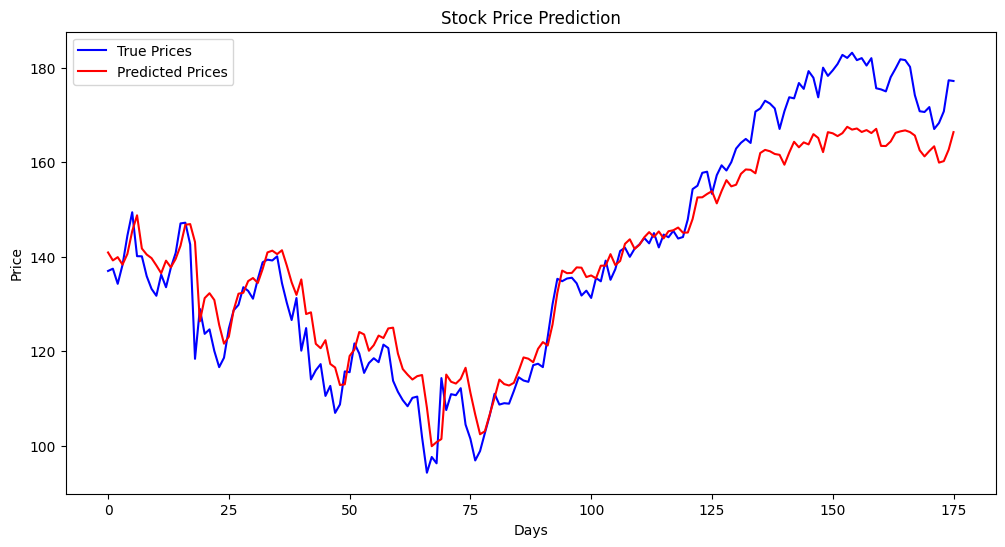

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(true_prices, label="True Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="red")
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()
